<a href="https://colab.research.google.com/github/massone99/visione_artificiale_colab_notebooks/blob/main/RGBDOdometryOpenCV_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SLAM (Simultaneous Localization And Mapping)**

In robotica, con l'acronimo SLAM si intende il problema in cui un robot mobile deve incrementalmente costruire una mappa in **real-time** dell'ambiente che sta esplorando, localizzandosi su di essa.

Tale problema è quindi composto da due task simultanei:
*   **mapping**: è il task in cui il robot costruisce una mappa dell'ambiente, percependo il mondo attraverso una serie di sensori;
*   **localization**: è il task in cui il robot si localizza sulla mappa.

Questi due task sono strettamente inter-dipendenti l'un l'altro, rendendo il problema estremamente complesso.

Infatti, per costruire una mappa dell'ambiente il robot deve conoscere la sua posizione in esso, ma per conoscere la sua posizione deve avere a disposizione una mappa.

![](https://drive.google.com/uc?id=1sGb1rCjn0NLyWrYCQgR-TS1jLiheFnEO)



## **Applicazioni**

Lo SLAM viene utilizzato in tutti quei contesti in cui si ha bisogno di una localizzazione robusta e precisa, ad esempio:


*   auto a guida autonoma;
*   esplorazioni spaziali (esempio di ciò sono i rover su Marte), in quanto tali robot devono muoversi con una certa autonomia perchè troppo distanti per essere comandati in modo efficiente dall'uomo;
*   robotica e scenari indoor, dove il GPS non performa sufficientemente bene;
*   in quei contesti in cui l'obiettivo è ottenere una mappa accurata dell'ambiente;
*   da un punto di vista filosofico, lo SLAM fornisce ai robot una conoscenza topologica dell'ambiente.

In generale il problema viene studiato per aumentare la capacità di comprensione dell'ambiente da parte dei robot, al fine di incrementarne l'autonomia.



E' un problema molto studiato attualmente nella comunità scientifica, di fatto è un "hot topic", un tema caldo.

Anche Meta recentemente con i suoi nuovi smart glasses ha investito molto in tal senso.

In [ ]:
from IPython.display import HTML
HTML("""<iframe width="560" height="315" src="https://www.youtube.com/embed/lzPmXjEEPmg" frameborder="0" allow="fullscreen" allowfullscreen></iframe>""")

## **Concetti di base**

1.   **è un problema probabilistico**. A causa del rumore dei sensori, ciò che il robot fa è sempre una **stima** della sua posa e della mappa.
2.   **deve essere un processo real-time**. Per mappe di enormi dimensioni la cosa si complica molto.
3.   **assume che il mondo sia statico**, ovvero che non cambia nel tempo. Nella realtà il mondo è mutevole, per questo è possibile apportare notevoli miglioramenti in questo ambito.

Nella teoria, lo SLAM può considerarsi un problema sostanzialmente risolto, esistono infatti in letteratura diverse formulazioni del problema e diverse soluzioni sono state presentate e realizzate. Nella pratica però essere funzionano bene solo in determinate condizioni, ad esempio quando la mappa è di dimensioni limitate e quando il mondo risulta pressochè statico.



Quindi una soluzione definitiva al problema ancora non esiste.


Nell'immagine sotto è rappresentata la formulazione del problema. I triangoli bianchi e grigi sono rispettivamente la posa reale e la posa stimata del robot, mentre le stelle bianche e grigie sono rispettivamente la posizione reale e stimata dei landmark, ovvero punti facilmente riconoscibili nell'ambiente.
Man mano che il robot si muove stima la sua nuova posa e, grazie al fatto che riosserva gli stessi landmark in istanti temporali differenti, è in grado di correggere questa stima.

![](https://drive.google.com/uc?id=1D239Q_6q2usZ5QLRg4mcUiOhTD4gHhHR)



## **Diverse formulazioni del problema**

Lo SLAM è un problema studiato da ormai tre decenni. Nel corso degli anni sono state proposte diverse formulazioni del problema, raggruppabili in due famiglie:



*   **filter-based**, storicamente la formulazione più antica;
*   **graph-based**, più recente, rappresenta oggi lo stato dell'arte.

Nello SLAM basato su grafi, tipicamente si fa uso di un **front-end** veloce (10-30Hz) per stimare lo spostamento del robot e creare un grafo delle pose, mentre un **back-end** più lento (1-5Hz) che lavora in contemporanea col front-end ottimizza tale grafo.

![](https://drive.google.com/uc?id=1yaAirzmUBtkqNTjI1AHT0YkYw_dshgwe)




## **Loop closure detection**

Come detto, mano a mano che il robot naviga un ambiente, l'odometria accumula un errore nel tempo detto **drift**. Per correggere tale errore, una componente fondamentale dello SLAM è la **loop closure detection**, ovvero il processo per cui un robot riconosce di essere tornato in un punto precedentemente visto. Quando il robot riconosce di essere tornato in un luogo già visitato, tutta la mappa può essere corretta di conseguenza.


Nell'immagine sotto è illustrato questo processo.
I triangoli blu e rossi sono rispettivamente le pose reali e stimate del robot. Nell'immagine di destra le pose stimate accumulano un errore man mano che il robot naviga l'ambiente. Quando però esso ritorna in un punto precedentemente visto e lo riconosce come tale, può far collassare la posa attuale su quella precedente associata allo stesso luogo, correggendo la mappa di conseguenza.

![](https://drive.google.com/uc?id=1JN1wcIaqpVXpFvSUqS1wtg3L7dKCqoI0)

Riconoscere un luogo già visitato è di fatto un problema molto complesso per un robot. Come riconoscere un luogo che cambia nel tempo?

![](https://drive.google.com/uc?id=1QidIOSXI5MnKyU6aur3k2b8OC_1meIGM)

O come riconoscere che due luoghi all'apparenza molto simili in realtà sono luoghi differenti?

![](https://drive.google.com/uc?id=14gNLqjdnngxQWmbKE79BZqNpDloRt0As)


# **Introduzione alla Visual Odometry**

Lo SLAM è un problema molto ampio e complesso, che coinvolge diverse discipline, che ha diverse formulazioni e può essere risolto con tecniche e algoritmi diversi a seconda dei sensori utilizzati, è composto da diversi sottoproblemi ecc...

Ciò che vedremo oggi è solo una sottoparte di esso, nello specifico è una sottoparte del front-end: la stima dell'odometria e più precisamente la **RGB-D visual odometry**.

## **Odometria**

Il termine *odometria* deriva dal greco ed è composto da due parole:


*   *odos*: strada
*   *metron*: misura

significa quindi "misura della strada".

In robotica l'odometria consiste nell'utilizzo delle acquisizioni dei sensori per stimare come il robot ha cambiato la sua posizione nel tempo.

A seconda dei sensori utilizzati si distinguono diversi tipi di odometria:



*   **wheel odometry**, con encoder montati su ruote;
*   **visual odometry**, a partire da immagini;
*   **LiDAR odometry**, a partire da acquisizioni laser 2D o 3D;
*   **inertial odometry**, effettuata con sensori inerziali come accelerometro e giroscopio;
*   una combinazione delle precedenti (ad esempio Visual-Inertial Odometry)





## **Visual Odometry**

La Visual Odometry è la stima dell'odometria a partire dalle immagini.

A seconda delle camere utilizzate, esistono diversi tipi di visual odometry:



*   **monoculare**, se si utilizza una normale camera monoculare;
*   **stereo**, se si utilizza una camera stereo, ovvero che cattura due flussi di immagini (tipicamente destra e sinistra, come la visione umana);
*   **RGB-D**, se si utilizza un depth camera, che fa uso di laser per catturare immagini di profondità.

Camera monoculare:

![](https://drive.google.com/uc?id=1Ujo-z5EwRSRxGo7b3YM9TPhRLuJBmuwm)

Camera stereo:

![](https://drive.google.com/uc?id=148lJAa3lZRIUB4JZhFQd5OGMITcjbOK9)

Depth camera:

![](https://drive.google.com/uc?id=1z9zG0JUNbEqpT9CFIgSMrg_XijCaXGmI)


# **Esercitazione: RGB-D odometry in python**

Nell'esercitazione di oggi creeremo un sistema di RGB-D Visual Odometry in python, facendo uso solo di due librerie: **numpy**, **opencv** (le altre librerie sono di utility).

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from google.colab.patches import cv2_imshow

## **Camera RGB-D**

Le camere RGB-D, oltre a catturare l'immagine RGB catturano anche immagini depth (RGB-Depth). Un'immagine depth è tipicamente un'immagine a singolo canale, ma con profondità a 16bit, contrariamente quindi alle immagini grayscale o RGB, che hanno rispettivamente uno e tre canali e che usano 8 bit per canale per rappresentare i valori dei pixel.

Quindi mentre per le immagini a 8 bit il valore dei pixel è in un range $[0, 255]$ (poichè i valori interi senza segno rappresentabili con 8 bit sono $2^8$), le immagini depth sono immagini a singolo canale con valori dei pixel nel range $[0, 65535]$ (i valori rappresentabili sono $2^{16}$).

Ciascun pixel nell'immagine depth rappresenta una distanza in millimetri dalla camera, moltiplicata per un fattore di scala che dipende dalla camera utilizzata.

\\

Immagine RGB acquisita

![](https://drive.google.com/uc?id=1kDjLr3RECjZQn1YxaDX7ZYE2dc7Tm7u_)

Corrispondente immagine depth

![](https://drive.google.com/uc?id=1cG2-MCyEnnFhTi9RiIv8LOTZWVEBwE1Y)





Ad esempio, il dataset che useremo oggi è stato acquisito con una camera in cui ciascun pixel delle immagini depth è la distanza in millimetri dagli oggetti. Cioè un pixel con valore 3000 nell'immagine depth significa che dista dalla camera 3000 millimetri e quindi 3 metri.

Altre camere possono avere altre rappresentazioni della depth, ad esempio il valore di ciascun pixel non è la distanza in millimetri, ma la distanza in millimetri moltiplicata per un fattore di scala.

Questo fattore di scala è detto **depth scale** ed è un valore che permette di trasformare la distanza come rappresentata nelle immagini depth in metri.
Nel nostro caso quindi la depth scale $= 0.001$ poichè se un pixel ha un valore di depth in millimetri, per trasformarlo in metri dobbiamo moltiplicarlo per $0.001$.

\\

Per catturare le immagini depth, le camere odierne fanno uso di tecnologia laser stereo, cioè un emettitore emette un raggio e un ricevitore a distanza nota cattura il raggio di ritorno. In base al tempo intercorso tra emissione e ricezione si calcola la distanza. Questa tecnologia è detta **Time-Of-Flight** (TOF).

![](https://drive.google.com/uc?id=1N7uQrcgW1m4ADZsJBvSeRQVuw3Z7nUbM)

\\

Essendo sensori stereoscopici, è possibile che si creino dei "buchi" nelle immagini, che sono i pixel neri. Questo perchè ci possono essere ostacoli che impediscono al raggio emesso di essere riflesso al ricevitore (è un principio simile a quello per cui il vostro naso vi impedisce di vedere con l'occhio sinistro ciò che vedete con l'occhio destro e viceversa).
Inoltre questi sensori hanno un range che va dai 10-11cm a decine di metri, ma sono precisi al millimetro solo in un range di 4-6 metri. Valori di depth inferiori al minimo o superiori al massimo sono messi a 0, quindi **il valore 0 rappresenta un valore non valido per la depth**.

Nel nostro caso il range massimo, essendo $[0, 65535]$ il range di valori rappresentabili ed essendo il valore di ogni pixel la distanza in millimetri da un oggetto, la camera arriva a misurare fino a 65535 millimetri di distanza, cioè 65 metri! Ma come detto, sopra i 4-6 metri l'errore comincia a diventare elevato.

### **Sistema di riferimento della camera**

Per capire come la camera rappresenta le immagini è necessario anche conoscere il suo sistema di riferimento (frame of reference).

Di seguito è riportata un'immagine del frame of reference della camera che è stata usata per catturare il dataset che useremo oggi. Camere diverse possono avere frame of reference diversi.

L'asse $X$ è l'asse orizzontale è cresce verso destra.

L'asse $Y$ è l'asse verticale e cresce verso il basso.

L'asse $Z$ è l'asse perpendicolare al piano della camera e cresce uscendo dalla camera.

![](https://drive.google.com/uc?id=13aPNiZA2qTboQxaDFuYOjgfBmTJdG3xi)


### **Parametri della camera**

Per poter acquisire un'immagine, la camera deve proiettare un oggetto dal mondo reale 3D al piano dei pixel 2D, applicando quindi una funzione $\mathbb{R}^{3} \rightarrow \mathbb{R}^{2}$ e per farlo ha bisogno di diversi parametri. Nell'esercitazione odierna ce ne bastano quattro: le coordinate del centro ottico $[c_x, c_y]$ e i valori della distanza focale della camera $[f_x, f_y]$.

![](https://drive.google.com/uc?id=1IdysKJA62bYGraN_tZeHKCX51QTCfeUB)

\\

Questi quattro parametri ci permettono di definire la **matrice intrinseca** della camera, detta $K$.

\begin{align}
   K =
    \begin{bmatrix}
           f_x & 0 & c_x\\
           0 & f_y & c_y\\
           0 & 0 & 1
    \end{bmatrix}
\end{align}

L'equazione che lega ciascun pixel $[u, v]$ al rispettivo punto nel mondo reale $[X, Y, Z]$ è la seguente.

\begin{align}
   \begin{bmatrix}
           u\\
           v\\
           1
    \end{bmatrix}
    =
    \frac{1}{Z}
    ⋅
    K
    ⋅
    \begin{bmatrix}
           X\\
           Y\\
           Z
    \end{bmatrix}
\end{align}

Quindi se vogliamo ottenere le coordinate di un pixel a partire da un punto 3D useremo le equazioni:

$u = \frac{(f_x \times X)} {Z} + c_x$

$v = \frac{(f_y \times Y)}{Z} + c_y$

Viceversa, se vogliamo proiettare un pixel 2D nel mondo 3D useremo le equazioni inverse:

\begin{align}
   \begin{bmatrix}
           X\\
           Y\\
           Z
    \end{bmatrix}
    =
    Z
    ⋅
    K^{-1}
    ⋅
    \begin{bmatrix}
           u\\
           v\\
           1
    \end{bmatrix}
\end{align}

e quindi

$X = \frac{(u - c_x) \times Z}{f_x}$

$Y = \frac{(v - c_y) \times Z}{f_y}$

dove

\begin{align}
   K^{-1} =
    \begin{bmatrix}
           \frac{1}{f_x} & 0 & \frac{-c_x}{f_x}\\
           0 & \frac{1}{f_y} & \frac{-c_y}{f_y}\\
           0 & 0 & 1
    \end{bmatrix}
\end{align}



in questo è necessario conoscere la $Z$ ed è proprio qui che entreranno in gioco le immagini depth.


### **La classe Camera**

La prima classe definita nell'esercitazione di oggi è la classe Camera.
Essa prenderà in input i quattro valori della matrice intrinseca e il fattore di scala della depth.

In [ ]:
class Camera:
    def __init__(self, fx, cx, fy, cy, depth_scale = 0.001):
      self.fx = fx
      self.cx = cx
      self.fy = fy
      self.cy = cy
      self.depth_scale = depth_scale

      self.K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]]) #intrinsic matrix

Il dataset è stato catturato con una camera che ha i seguenti parametri.

In [ ]:
fx, cx, fy, cy, depth_scale = 6.1145098876953125e+02, 4.3320397949218750e+02, 6.1148571777343750e+02, 2.4947302246093750e+02, 0.001

## **Trasformazioni 3D**

L'odometria stima l'evoluzione della posa del robot nel tempo.

Una **posa** è l'insieme di una **orientazione** e una **posizione**. L'orientazione rappresenta un angolo rispetto all'origine del sistema di riferimento, la posizione rappresenta una traslazione, sempre rispetto all'origine.

Una **trasformazione relativa** invece è lo spostamento fatto dal robot tra due pose, e si rappresenta in modo analogo alla posa, con una rotazione e una traslazione.

In generale, queste trasformazioni nello spazio 3D sono rappresentate da matrici.

\\

Una rotazione 3D è rappresentabile attraverso una matrice $3 \times 3$ ortogonale, quindi la sua inversa è la trasposta e il determinante è 1. Per questo motivo prende il nome di **Special Orthogonal Group**.

$SO(3) = \{\mathbf{R} \in \mathbb{R}^{3 \times 3}|\mathbf{R}\mathbf{R}^{T} = \mathbf{I}, det(\mathbf{R}) = 1\}$

\\

Una trasformazione rigida 3D (senza fattori di scala) è rappresentabile attraverso una matrice $4 \times 4$ in cui si ha una matrice di rotazione $3 \times 3$ e un vettore traslazione $3 \times 1$. Questo tipo di trasformazioni sono dette Euclidee, da qui il nome **Special Euclidean Group**.


$SE(3)\ = \Big\{\mathbf{T} = {\begin{bmatrix}
\mathbf{R} & \mathbf{t}\\
\mathbf{0}^{T} & 1
\end{bmatrix}} \in \mathbb{R}^{4 \times 4}|\mathbf{R} \in  SO(3), \mathbf{t} \in \mathbb{R}^{3}  \Big\}$

\\

Il vettore traslazione $\mathbf{t}$ è dato in ordine dalle coordinate $x, y, z$.

$\mathbf{t} = \begin{bmatrix}\mathbf{t}_x \\ \mathbf{t}_y \\ \mathbf{t}_z \end{bmatrix} $



### **La posa inziale**

La posa iniziale viene tipicamente rappresentata agli origini degli assi, con una orientazione che è l'identità.

$\mathbf{t} = (0, 0, 0)$

$\mathbf{R} = \mathbf{I} \in \mathbb{R}^{3 \times 3}$

La posa iniziale è quindi una matrice identità $4 \times 4$.

$\mathbf{P_0} = {\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}}$

### **Aggiornare una posa**

Partendo dalla posa iniziale come si aggiorna tale posa mano a mano che il robot si muove?

L'odometria si occupa di calcolare lo spostamento del robot tra un'acquisizione del sensore e la successiva, calcola quindi la trasformazione relativa. Per aggiornare la posa basta fare il prodotto scalare tra la vecchia posa e la trasformazione relativa calcolata.

$\mathbf{P}_{new} = \mathbf{P}_{old} \cdot \mathbf{T}_{relative}$

che è equivalente a

$\mathbf{t}_{new} = \mathbf{t}_{old} + (\mathbf{R}_{old} \cdot \mathbf{t}_{relative})$

$\mathbf{R}_{new} = \mathbf{R}_{relative} \cdot \mathbf{R}_{old} $



![](https://drive.google.com/uc?id=1lHbGoaJBLyoeb6cygcJMoEDGratgnwX6)

Rappresentando il problema per chiarificare le cose, il robot (in blu) si trova inizialmente all'origine degli assi e ha la sua posa $\mathbf{P_0}$.

Il robot si sposta e l'odometria stima la trasformazione relativa $\mathbf{T_0}$ (in rosso).

Ora il robot si trova nella posa $\mathbf{P_1}$.

Il robot si sposta e l'odometria stima la trasformazione relativa $\mathbf{T_1}$ (in rosso).

Ora il robot si trova nella posa $\mathbf{P_2}$ e così via per tutto il processo.


## **Visual odometry**

La pipeline più comune per la Visual Odometry è la seguente.

![](https://drive.google.com/uc?id=1PIy02rz2dcZe6Q6yWC32wEc3FilZIE2J)

Si susseguono vari step:


1.   il sensore (nel nostro caso una depth camera) acquisisce un nuovo frame;
2.   si fa Feature Detection, ovvero da questo frame vengono estratte feature salienti;
3.   si cerca di capire se queste feature matchano con quelle estratte dal frame precedente, si fa quindi Feature Matching (lasciamo perdere il Tracking per ora);
4.   se risultano dei buoni match, ecco che si può procedere con la Motion Estimation, ovvero si stima lo spostamento effettuato;
5.   si possono ottimizzare le pose stimate mediante Bundle Adjustment (problema complesso che noi non vedremo).

Quindi noi oggi vedremo come effettuare i punti dall'1 al 4.




### **1. Acquisizione di un frame**

Nel nostro caso i frame non sono acquisiti da una camera in real-time, ma sono salvati come immagini.

Scarichiamo il dataset. Verranno create la cartella **color** e **aligned_depth** rispettivamente per le immagini RGB e di profondità.

In [ ]:
#! gdown https://drive.google.com/file/d/1E24G9LSV_AC74olmEGN-C40j5783jHRS/view?usp=sharing

!gdown https://drive.google.com/uc?id=1E24G9LSV_AC74olmEGN-C40j5783jHRS

!unzip /content/dataset.zip

!rm /content/dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1E24G9LSV_AC74olmEGN-C40j5783jHRS
To: /content/dataset.zip
100% 641M/641M [00:06<00:00, 93.7MB/s]
Archive:  /content/dataset.zip
  inflating: aligned_depth/1560000083.949189.png  
  inflating: aligned_depth/1560000083.982551.png  
  inflating: aligned_depth/1560000084.015912.png  
  inflating: aligned_depth/1560000084.049274.png  
  inflating: aligned_depth/1560000084.082635.png  
  inflating: aligned_depth/1560000084.115996.png  
  inflating: aligned_depth/1560000084.149358.png  
  inflating: aligned_depth/1560000084.182719.png  
  inflating: aligned_depth/1560000084.216081.png  
  inflating: aligned_depth/1560000084.249442.png  
  inflating: aligned_depth/1560000084.282803.png  
  inflating: aligned_depth/1560000084.316164.png  
  inflating: aligned_depth/1560000084.349526.png  
  inflating: aligned_depth/1560000084.382706.png  
  inflating: aligned_depth/1560000084.416067.png  
  inflating: aligned_depth/1560000084.449429.png  
  i

Per capire il tragitto fatto dal robot, possiamo vedere questi due video, che mostrano la sequenza di frame [RGB](https://drive.google.com/file/d/12sc8PHAGAnkdLEqH8xGDrhkq--O-ryXT/view?usp=sharing) e [depth](https://drive.google.com/file/d/1FTc8djIQlA28t4dduqZDnJklN14HYuDf/view?usp=sharing).


Creiamo una funzione per caricare le immagini RGB-D come numpy array.

In [ ]:
def load_data(rgb_path, depth_path):
  rgb = cv2.imread(rgb_path, cv2.IMREAD_UNCHANGED)
  depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)

  return rgb, depth

Carichiamo già tutti i path per le immagini RGB e depth.

In [ ]:
rgb_paths = glob("/content/color/*")
depth_paths = glob("/content/aligned_depth/*")

rgb_paths.sort()
depth_paths.sort()

#### **La classe Frame**

Creiamo ora la classe **Frame**, per rappresentare le acquisizioni del sensore.

In [ ]:
class Frame:
 def __init__(self, rgb, depth):
   self.rgb = rgb
   self.depth = depth

### **2. Feature Detection**

Come già visto nel corso, le **feature** (o keypoints) sono punti facilmente riconoscibili nelle immagini. Ma cosa vuol dire facilmente riconoscibili?
Ad esempio dove il gradiente cambia in tutte le direzioni, quindi gli spigoli sono ottimi keypoints.

\\

Nell'immagine sotto c'è un esempio di keypoints estratti.

![](https://drive.google.com/uc?id=1zeldpQQHW_wmgN0FgbSmtV7bzLUn2IUL)

\\

OpenCV mette a disposizione moltissimi algoritmi per la detection di feature.
Noi faremo uso di [ORB](https://docs.opencv.org/4.x/d1/d89/tutorial_py_orb.html), un detector buono e molto veloce.

In [ ]:
feature_detector = cv2.ORB_create(nfeatures = 1000)

#### **Prova col primo frame**

Questi estrattori lavorano su immagini grayscale, mentre noi abbiamo immagini RGB.

Dobbiamo ridefinire la nostra classe Frame, per fare in modo che mantenga anche le immagini grayscale.

In [ ]:
class Frame:
 def __init__(self, rgb, depth):
   self.rgb = rgb
   self.depth = depth
   self.gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

In [ ]:
rgb, depth = load_data(rgb_paths[0], depth_paths[0])

frame = Frame(rgb, depth)

La funzione [detect](https://docs.opencv.org/4.x/d0/d13/classcv_1_1Feature2D.html#a5968e9bc8497a8eb845272b9442559f3) ritorna un oggetto [Keypoint](https://docs.opencv.org/4.x/d2/d29/classcv_1_1KeyPoint.html) che mantiene diversi parametri.

In [ ]:
keypoints = feature_detector.detect(frame.gray)

print("N keypoints detected:", len(keypoints))

N keypoints detected: 1000


Con la funzione di OpenCV [drawKeypoints](https://docs.opencv.org/4.x/d4/d5d/group__features2d__draw.html#ga5d2bafe8c1c45289bc3403a40fb88920) possiamo graficare l'immagine con i keypoints estratti.

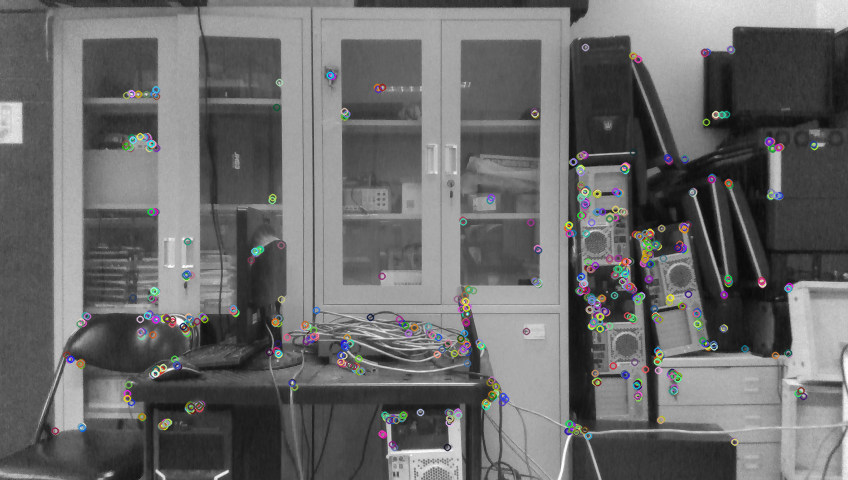

In [ ]:
out = cv2.drawKeypoints(frame.gray, keypoints, 0)
cv2_imshow(out)

### **3. Feature Matching**

Per effettuare Feature Matching abbiamo bisogno di due Frame successivi. Per effettuare un matching i keypoints però non sono sufficienti, dobbiamo calcolare i **descrittori** dei keypoints.

Un descrittore descrive la porzione di immagine che fa da contorno ai keypoints, in modo che siano il più possibile univoci.

Il matching avviene infatti tra i descrittori, non tra i keypoints!


![](https://drive.google.com/uc?id=1WK9RAHcwLGyuXhPwe1sVUrnKkaXFWNRe)

Come estrattore dei descrittori usiamo sempre ORB.

In [ ]:
descriptor_extractor = cv2.ORB_create()

Siccome il matching avviene tra Frame successivi, la classe Frame deve mantenere anche i keypoints rilevati e i descrittori estratti.

In [ ]:
class Frame:
  def __init__(self, rgb, depth):
    self.rgb = rgb
    self.depth = depth
    self.gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

  def set_keypoints(self, keypoints):
    self.keypoints = keypoints

  def set_descriptors(self, descriptors):
    self.descriptors = descriptors

OpenCV permette di usare diversi tipi di matcher per effettuare il matching tra descrittori.

Noi useremo un [Brute-Force matcher](https://docs.opencv.org/4.x/d3/da1/classcv_1_1BFMatcher.html). [Qui](https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html) si può trovare un esempio di matching dei descrittori.



Inoltre faremo uso dell'algoritmo che prende il nome di **Lowe's ratio test** per effettuare un matching robusto.

Definiamo innanzitutto il matcher. Usiamo la [distanza di Hamming](https://it.wikipedia.org/wiki/Distanza_di_Hamming) come metrica per calcolare la distanza tra i descrittori.

In [ ]:
feature_matcher = cv2.BFMatcher(cv2.NORM_HAMMING)

#### **Lowe's ratio test**

Il Lowe's ratio test si avvale dell'algoritmo K-Nearest Neighbors per definire se il primo NN è effettivamente tale, escludendo quindi evenutali punti che potrebbero essere degli outliers.

Immaginiamo di aver estratto i descrittori da due frame successivi e aver fatto su un descrittore $d_{11}$ della prima immagine un K-NN con K = 2 e aver trovato che i 2 descrittori più simili nella seconda immagine siano $d_{21}$ e $d_{22}$.

Immaginando quindi ora di essere nello spazio dei descrittori, è possibile graficare questa situazione (immaginiamo per semplicità di essere in un piano 2D). Ovviamente più sono vicini, più significa che sono simili, più sono lontani più significa che sono differenti.

\\

Immaginiamo la seguente situazione:

![](https://drive.google.com/uc?id=1lsJMFkZ5DVX-0Q0zA75hYUqOFM1cC9FZ)

In questo caso le distanze $\mathbf{D1}$ e $\mathbf{D2}$ sono molto simili, cioè $d_{21}$ è il descrittore più simile a $d_{11}$, ma anche $d_{22}$ è molto simile. E' difficile dire se $d_{21}$ sia veramente il descrittore più simile o se questo risultato sia semplicemente causato da una imprecisione nel sensore da una condizione non ottimale (di illuminazione ad esempio).

\\

Immaginiamo ora invece questa situazione:

![](https://drive.google.com/uc?id=17FmVxZoDkFhgZT9P7K-e63oeNgZOw1WH)

In questo caso le distanze $\mathbf{D1}$ e $\mathbf{D2}$ sono molto differenti, $d_{21}$ è il descrittore di gran lunga più simile a $d_{11}$. In questo caso è possibile affermare con ragionevole certezza che $d_{21}$ sia effettivamente il descrittore più simile a $d_{11}$.

Per effettuare il test di Lowe quindi si definisce una soglia in $[0, 1]$ e il primo vicino è considerato tale se il rapporto tra la sua distanza dal descrittore che si sta matchando e la distanza del secondo vicino è minore di tale soglia.

$\frac{\mathbf{D1}} {\mathbf{D2}} < threshold$

che equivale a dire

$\mathbf{D1} < \mathbf{D2} \times threshold$

allora $d_{21}$ è effettivamente il descrittore che matcha con $d_{11}$.

#### **Prova con i primi due frame**

Creiamo i frame per le prime due immagini.

In [ ]:
rgb, depth = load_data(rgb_paths[0], depth_paths[0])
prev_frame = Frame(rgb, depth)

rgb, depth = load_data(rgb_paths[1], depth_paths[1])
curr_frame = Frame(rgb, depth)

Calcoliamo keypoints e descrittori. Per i descrittori utilizziamo la funzione [compute](https://docs.opencv.org/4.x/d0/d13/classcv_1_1Feature2D.html#ab3cce8d56f4fc5e1d530b5931e1e8dc0). Tale funzione ritorna una tupla (keypoints, descrittori), ovvero ritorna anche i keypoints per cui è stato possibile calcolare i descrittori.

In [ ]:
keypoints = feature_detector.detect(prev_frame.gray)
keypoints, descriptors = descriptor_extractor.compute(prev_frame.gray, keypoints)

prev_frame.set_keypoints(keypoints)
prev_frame.set_descriptors(descriptors)

keypoints = feature_detector.detect(curr_frame.gray)
keypoints, descriptors = descriptor_extractor.compute(curr_frame.gray, keypoints)

curr_frame.set_keypoints(keypoints)
curr_frame.set_descriptors(descriptors)

Creiamo una funzione che effettui il matching tra feature con il Lowe's ratio test.

Usiamo la funzione [knnMatch](https://docs.opencv.org/4.x/db/d39/classcv_1_1DescriptorMatcher.html#a378f35c9b1a5dfa4022839a45cdf0e89) dei Brute-Force matcher di OpenCV con K = 2, la quale ritorna una lista di tuple.

Ciascuna tupla contine due [DMatch](https://docs.opencv.org/4.x/d4/de0/classcv_1_1DMatch.html) (perchè abbiamo fatto 2-NN), ovvero i due match della seconda immagine che sono più simili a ciascun descrittore della prima immagine.

Un DMatch ha il campo *distance*, che rappresenta la distanza dal descrittore della prima immagine.

In [ ]:
def robust_match(feature_matcher, prev_descriptors, curr_descriptors, nn_threshold = 0.7):
  good_matches = []
  matches = feature_matcher.knnMatch(prev_descriptors, curr_descriptors, k=2)

  for (nn1,nn2) in matches:
    if nn1.distance < nn_threshold * nn2.distance:
      good_matches.append(nn1)

  return good_matches

Un valore ragionevole per la soglia è $0.7$. Più tale valore è piccolo, più si scartano outliers, ma si rischia poi di scartare anche match corretti.

In [ ]:
nn_threshold = 0.7

good_matches = robust_match(feature_matcher, prev_frame.descriptors, curr_frame.descriptors, nn_threshold)

print("N good matches: ", len(good_matches))

N good matches:  664


Utilizziamo la funzione di OpenCV [drawMatches](https://docs.opencv.org/4.x/d4/d5d/group__features2d__draw.html#gad8f463ccaf0dc6f61083abd8717c261a) per visualizzare i match rilevati.

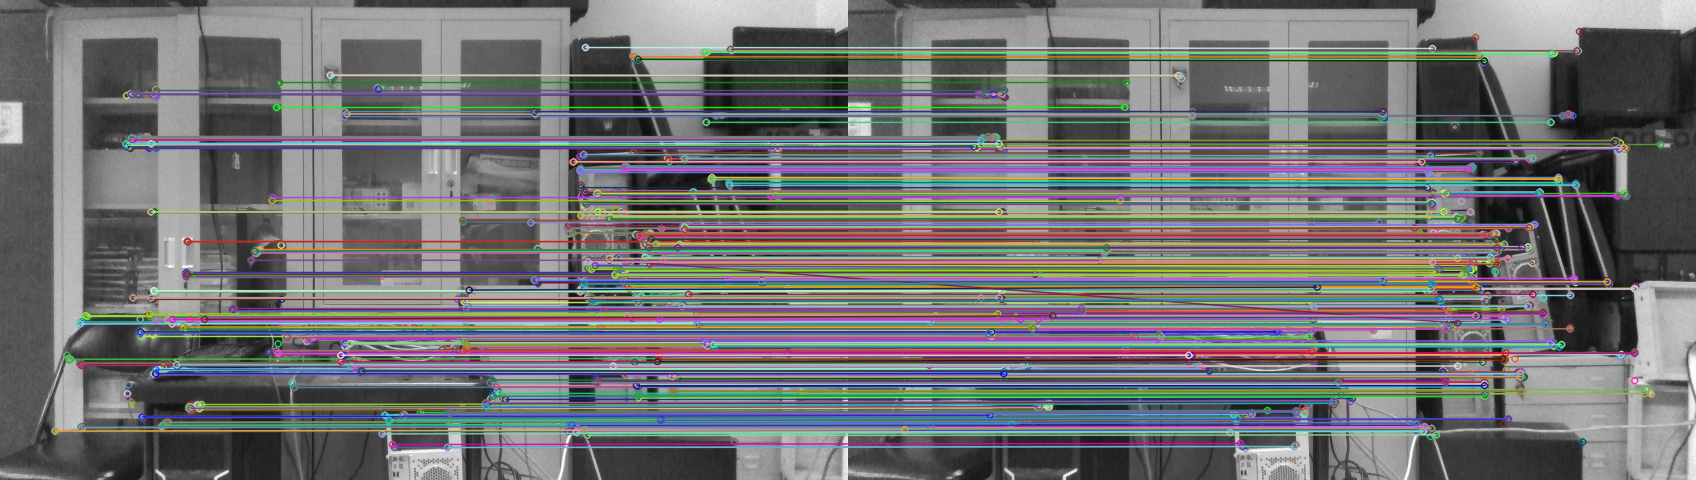

In [ ]:
out = cv2.drawMatches(prev_frame.gray, prev_frame.keypoints, curr_frame.gray, curr_frame.keypoints, good_matches, 0)

cv2_imshow(out)

### **4. Motion Estimation**

Lo scopo della Visual Odometry è capire come il robot si sta muovendo.

Finora abbiamo estratto i keypoints e i descrittori e li abbiamo matchati. Nel seguito lo scopo è fare quanto segue:

al tempo $t$ il robot osserva il mondo in una certa configurazione. Dopodichè effettua uno spostamento e al tempo $t+1$ il robot osserva il mondo e lo vede in modo differente. Grazie al matching di feature però è in grado di riconoscere dei punti che aveva visto al tempo $t$. Come si è mosso quindi per far sì che quei punti, che prima erano visti in un determinato modo, in una determinata posizione nell'immagine, ora invece siano visti come effettivamente li vede?

L'immagine sotto rappresenta questo concetto. In blu abbiamo il robot, a sinistra è al tempo $t$, a destra al tempo $t+1$ e i punti verdi sono i punti che matcha tra i due frame, quindi che riconosce effettivamente come i medesimi punti visti da due posizioni diverse. Qual è lo spostamento $\mathbf{T}$ che ha effettuato?

![](https://drive.google.com/uc?id=11HVsDw_iTbWmujkbGogA4dboxinElyhu)





A seconda dei sensori utilizzati, esistono diversi tipi di algoritmi di Motion Estimation.

![](https://drive.google.com/uc?id=1Z4X02m9xrmb3C9N6KCXrOWWH1SaIboWs)

\\

Gli algoritmi 2D-2D sono tipicamente utilizzati quando si hanno a disposizione solo immagini monoculari, ovvero quando non si possono proiettare i pixel nello spazio 3D. Sono algoritmi poco precisi proprio perchè si perde la profondità dello spazio.

\\

Gli algoritmi 3D-3D sono utilizzati quando è possibile proiettare i pixel nello spazio 3D, ad esempio quando si utilizzano camere stereo e RGB-D. Lo scopo è quello di allineare i punti 3D. Uno degli algoritmi più noti è l'**iterative closest point**.

![](https://drive.google.com/uc?id=1fu0HJ8G47lJYBiIlDd1doQtx-hrQ-dc9)

\\

Noi oggi vedremo un algoritmo 3D-2D, che prende il nome di [Perspective-n-Point](https://en.wikipedia.org/wiki/Perspective-n-Point) (detto PnP).






#### **PnP**



Questo algoritmo ha dimostrato di essere più preciso e computazionalmente più efficiente rispetto agli algoritmi 3D-3D. E' un algoritmo 3D-2D ovvero solo i punti del frame precedente sono proiettati nel mondo 3D, i punti del frame corrente rimangono 2D.

\\

Come algoritmo nasce per trovare qual è la posizione di un oggetto nel mondo 3D rispetto al sistema di riferimento della camera, minimizzando l'errore di proiezione dei punti dal mondo 3D ai pixel 2D.

Nell'immagine sotto, i punti arancioni sono punti nel mondo 3D e vengono proiettati sul piano dei pixel come i punti gialli. Lo scopo del PnP è trovare la trasformazione che minimizzi l'errore di proiezione per ciascun punto.

![](https://drive.google.com/uc?id=1utRys21AWYy5RYJ_kCjwc8rRB6YMi7vZ)

Per la Visual Odometry, il PnP viene utilizzato in modo simile.

Grazie alle immagini depth, è possibile proiettare i keypoints del frame precedente nello spazio 3D (punti arancioni nell'immagine sotto). Avendo i match di ciascun keypoint per il frame corrente è possibile utilizzare il PnP per minimizzare l'errore di proiezione di questi punti nel frame corrente, ottenendo la trasformazione $\mathbf{T}$ tra il sistema di riferimento della camera e quello del mondo 3D.


![](https://drive.google.com/uc?id=1e92GbT3rw0SgJ9BNk9z3FyABBc_JglGl)


L'obiettivo della Visual Odometry però non è ottenere la posizione di un oggetto (o dei punti) nel mondo 3D rispetto alla camera, ma la posizione della camera rispetto al mondo 3D, che è quindi $\mathbf{T^{-1}}$.
Cioè non si vuole calcolare come il mondo si è spostato dalla prospettiva della camera, ma come la camera si è spostata (e quindi il robot) dalla prospettiva del mondo.

Ricordando che una matrice di trasformazione è composta da una matrice di rotazione ortogonale (quindi l'inversa è la trasposta), è possibile calcolare la trasformazione inversa in modo computazionalmente efficiente come segue:

$\mathbf{T^{-1}} = \begin{bmatrix} \mathbf{R}^T & -\mathbf{R}^T \cdot \mathbf{t}\\
\mathbf{0}^t & 1\end{bmatrix}$

#### **Modifica alla classe Camera**

Sapendo ora che è necessario proiettare i punti nello spazio 3D e ricordando la formula per farlo

$X = \frac{(u - c_x) \times Z}{f_x}$

$Y = \frac{(v - c_y) \times Z}{f_y}$

ridefiniamo la classe Camera, con un metodo apposito.

In [ ]:
class Camera:
    def __init__(self, fx, cx, fy, cy, depth_scale = 0.001):
      self.fx = fx
      self.cx = cx
      self.fy = fy
      self.cy = cy
      self.depth_scale = depth_scale

      self.K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]]) #intrinsic matrix

    def pixel2camera(self, pt, depth):
      """
      pt = (u, v)
      depth = Z

      Application of the formula:
      X = (u - cx) * Z / fx
      Y = (v - cy) * Z / fy

      return the 3D world point (X, Y, Z)
      """
      return np.array([(pt[0] - self.cx) * depth / self.fx, (pt[1] - self.cy) * depth / self.fy, depth])

In [ ]:
camera = Camera(fx, cx, fy, cy, depth_scale)

#### **Calcolo dell'odometria tra i primi due frame**

La posa iniziale, come detto in precedenza, è una matrice identità $4 \times 4$.

In [ ]:
initial_pose = np.eye(4)

Abbiamo già estratto e matchato le feature. Ora dobbiamo proiettare i keypoint matchati del frame precedente nello spazio 3D.

I match mantengono al loro interno due campi:
*   **queryIdx**, che è l'indice del keypoint matchato nel frame precedente;
*   **trainIdx**, che è l'indice del keypoint matchato nel frame corrente;

Per ogni match, si fa uso delle coordinate dei pixel del keypoint corrispondente nel frame precedente e la rispettiva depth, data dalla depth image. Come indici si utilizzano prima la coordinata y e poi la coordinata x perchè OpenCV utilizza le immagini nel formato (height, width).

Se la depth è valida (!= 0) allora la depth viene trasformata in metri grazie alla depth scale e il punto viene proiettato nello spazio 3D.
Per ciascun keypoint valido, viene mantenuto il corrispondente keypoint nel frame corrente come punto 2D.

In sostanza, *prev_pts_3D* conterrà i keypoint matchati e con depth valida del frame precedente, proiettati nello spazio 3D, *curr_pts_2D* contiene i rispettivi keypoint matchati nel frame corrente, nello spazio 2D.

In [ ]:
prev_pts_3D = []
curr_pts_2D = []
for m in good_matches:
  pt = prev_frame.keypoints[m.queryIdx].pt
  d = prev_frame.depth[int(pt[1]), int(pt[0])]

  if d != 0:
    depth = d * camera.depth_scale
    point3D = camera.pixel2camera(pt, depth)

    prev_pts_3D.append(point3D)
    curr_pts_2D.append(curr_frame.keypoints[m.trainIdx].pt)


prev_pts_3D, curr_pts_2D = np.array(prev_pts_3D), np.array(curr_pts_2D)

OpenCV mette a disposizione varie implementazioni dell'algoritmo PnP. Noi utilizziamo la funzione [solvePnPRansac](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga50620f0e26e02caa2e9adc07b5fbf24e), la quale applica anche l'algoritmo Ransac per l'identificazione degli inliners, scartando eventuali outliers.

Tale funzione ritorna quattro valori:

*   un booleano che indica se il PnP è andato a buon fine;
*   una rotazione come vettore $3 \times 1$. E' un modo differente di rappresentare le rotazioni in 3D, ma è equivalente alla matrice di rotazione. Per convertirlo in matrice facciamo uso della funzione [Rodrigues](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga61585db663d9da06b68e70cfbf6a1eac);
*   una traslazione come vettore $3 \times 1$;
*   una lista di indici, corrispondenti agli inliners.

In [ ]:
solved, r, t, inliners = cv2.solvePnPRansac(prev_pts_3D, curr_pts_2D, camera.K, None, reprojectionError=2.0, confidence=0.99)

Se il PnP è riuscito, invertiamo la trasformazione relativa $\mathbf{T}$ per ottenere $\mathbf{T^{-1}}$.

In [ ]:
if solved:
  R, _ = cv2.Rodrigues(r, None)
  rel_T = np.eye(4)
  rel_T[:3, :3] = R.T
  rel_T[:3, 3] = (-R.T @ t)[..., 0] #dimensionalità (3, 1), vuole (3,)



Concatendando ora la posa iniziale con la trasformazione relativa otteniamo la nuova posa.

Ovviamente la nuova posa è uguale alla trasformazione relativa perchè la posa iniziale è l'identità. Man mano che si concatenano nuove trasformazioni relative questa cambia.


In [ ]:
new_pose = initial_pose @ rel_T

print("Relative transformation:\n", rel_T)
print("New pose:\n", new_pose)

Relative transformation:
 [[ 9.99998559e-01 -1.69407153e-04  1.68940483e-03 -1.66856459e-03]
 [ 1.71577537e-04  9.99999160e-01 -1.28464122e-03  2.74275230e-03]
 [-1.68918578e-03  1.28492923e-03  9.99997748e-01 -6.61356583e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
New pose:
 [[ 9.99998559e-01 -1.69407153e-04  1.68940483e-03 -1.66856459e-03]
 [ 1.71577537e-04  9.99999160e-01 -1.28464122e-03  2.74275230e-03]
 [-1.68918578e-03  1.28492923e-03  9.99997748e-01 -6.61356583e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### **Algoritmo definitivo**

Rendiamo ora l'algoritmo iterativo su tutti i frame disponibili del dataset.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from google.colab.patches import cv2_imshow

In [ ]:
def load_data(rgb_path, depth_path):
  rgb = cv2.imread(rgb_path, cv2.IMREAD_UNCHANGED)
  depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)

  return rgb, depth

In [ ]:
rgb_paths = glob("/content/color/*")
depth_paths = glob("/content/aligned_depth/*")

rgb_paths.sort()
depth_paths.sort()

In [ ]:
class Camera:
    def __init__(self, fx, cx, fy, cy, depth_scale = 0.001):
      self.fx = fx
      self.cx = cx
      self.fy = fy
      self.cy = cy
      self.depth_scale = depth_scale

      self.K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]]) #intrinsic matrix

    def pixel2camera(self, pt, depth):
      """
      pt = (u, v)
      depth = Z

      Application of the formula:
      X = (u - cx) * Z / fx
      Y = (v - cy) * Z / fy

      return the 3D world point (X, Y, Z)
      """
      return np.array([(pt[0] - self.cx) * depth / self.fx, (pt[1] - self.cy) * depth / self.fy, depth])

Aggiungiamo alla classe Frame la sua posa.

Miglioriamo anche la detection di feature aggiungendo al Frame una maschera che verrà usata poi della funzione *detect* del feature detector. Tale maschera evita che vengano estratte feature dove la depth non è valida, evitando di avere keypoints che non possono essere proiettati in 3D.

In [ ]:
class Frame:
  def __init__(self, rgb, depth):
    self.rgb = rgb
    self.depth = depth
    self.gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    self.mask = np.zeros(depth.shape, np.uint8)
    self.mask[depth != 0] = 255

  def set_keypoints(self, keypoints):
    self.keypoints = keypoints

  def set_descriptors(self, descriptors):
    self.descriptors = descriptors

  def set_pose(self, pose):
    self.pose = pose

Definiamo una classe *VisualOdometry* per effettuare i quattro step visti oggi.

In [ ]:
class VisualOdometry:
  def __init__(self, feature_detector, descriptor_extractor, feature_matcher, camera):
    self.feature_detector = feature_detector
    self.descriptor_extractor = descriptor_extractor
    self.feature_matcher = feature_matcher
    self.camera = camera

  def detect_features(self, frame):
    keypoints = self.feature_detector.detect(frame.gray, frame.mask)
    frame.set_keypoints(keypoints)

  def extract_descriptors(self, frame):
    keypoints, descriptors = self.descriptor_extractor.compute(frame.gray, frame.keypoints)
    frame.set_keypoints(keypoints)
    frame.set_descriptors(descriptors)

  def robust_match(self, prev_descriptors, curr_descriptors, nn_threshold = 0.7):
    good_matches = []
    matches = self.feature_matcher.knnMatch(prev_descriptors, curr_descriptors, k=2)

    for (nn1,nn2) in matches:
      if nn1.distance < nn_threshold * nn2.distance:
        good_matches.append(nn1)


    return good_matches

  def compute_motion_estimation_3D_2D(self, prev_frame, curr_frame, good_matches):
    prev_pts_3D = []
    curr_pts_2D = []
    for m in good_matches:
      pt = prev_frame.keypoints[m.queryIdx].pt
      d = prev_frame.depth[int(pt[1]), int(pt[0])]

      if d != 0:
        depth = d * self.camera.depth_scale
        point3D = self.camera.pixel2camera(pt, depth)

        prev_pts_3D.append(point3D)
        curr_pts_2D.append(curr_frame.keypoints[m.trainIdx].pt)


    prev_pts_3D = np.array(prev_pts_3D)
    curr_pts_2D = np.array(curr_pts_2D)

    solved, r, t, inliners = cv2.solvePnPRansac(prev_pts_3D, curr_pts_2D, self.camera.K, None, reprojectionError=2.0, confidence=0.99)

    rel_T = np.eye(4)

    if solved:
      R, _ = cv2.Rodrigues(r, None)
      rel_T[:3, :3] = R.T
      rel_T[:3, 3] = (-R.T @ t)[..., 0] #dimensionalità (3, 1), vuole (3,)

    return rel_T


In [ ]:
fx, cx, fy, cy, depth_scale = 6.1145098876953125e+02, 4.3320397949218750e+02, 6.1148571777343750e+02, 2.4947302246093750e+02, 0.001
nn_threshold = 0.7

camera = Camera(fx, cx, fy, cy, depth_scale)

rgb, depth = load_data(rgb_paths[0], depth_paths[0])
frame = Frame(rgb, depth)
frame.set_pose(np.eye(4))
frames = [frame]

feature_detector = cv2.ORB_create(1000)
descriptor_extractor = cv2.ORB_create()
feature_matcher = cv2.BFMatcher(cv2.NORM_HAMMING)

vo = VisualOdometry(feature_detector, descriptor_extractor, feature_matcher, camera)
vo.detect_features(frame)
vo.extract_descriptors(frame)

for i in range(1, len(rgb_paths)):

  rgb, depth = load_data(rgb_paths[i], depth_paths[i])
  frame = Frame(rgb, depth)
  last_frame = frames[-1]

  vo.detect_features(frame)
  vo.extract_descriptors(frame)

  good_matches = vo.robust_match(last_frame.descriptors, frame.descriptors, nn_threshold)

  rel_T = vo.compute_motion_estimation_3D_2D(last_frame, frame, good_matches)
  frame.set_pose(last_frame.pose @ rel_T)
  frames.append(frame)



### **Graficare il path**

Come detto in precedenza, il sistema di riferimento della camera è il seguente:

![](https://drive.google.com/uc?id=13aPNiZA2qTboQxaDFuYOjgfBmTJdG3xi)

Volendo quindi graficare il path percorso dal robot come se fosse in 2D, lasciando perdere l'asse verticale, dobbiamo mantenere l'asse Z e l'asse X.

\\

Ricordando che le nostre pose sono rappresentate attraverso matrici di trasformazione $\mathbf{T}$, composte nel seguente modo

$\mathbf{T} = \begin{bmatrix} \mathbf{R}_{00} & \mathbf{R}_{01} & \mathbf{R}_{02} & \mathbf{t}_x \\
\mathbf{R}_{10} & \mathbf{R}_{11} & \mathbf{R}_{12} & \mathbf{t}_y \\
\mathbf{R}_{20} & \mathbf{R}_{21} & \mathbf{R}_{22} & \mathbf{t}_z \\
0 & 0 & 0 & 1
\end{bmatrix}$

dovremo andare a prendere gli elementi $\mathbf{t}_x$ e $\mathbf{t}_z$ negli indici corrispondenti.

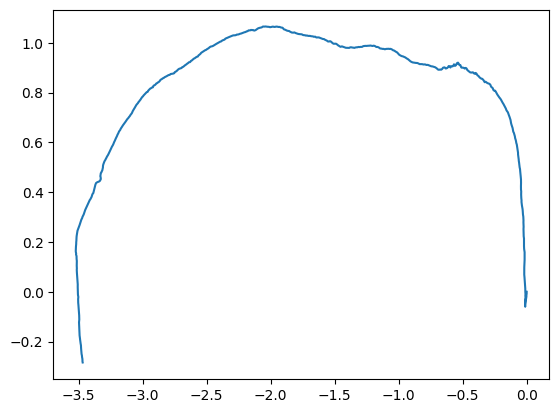

In [ ]:
x_feature_matching = [frame.pose[0, 3] for frame in frames]
z_feature_matching = [frame.pose[2, 3] for frame in frames]

plt.plot(x_feature_matching, z_feature_matching)
plt.show()

### **3. Feature Tracking**

Tornando indietro nella pipeline di Visual Odometry, oltre al Feature Matching esiste anche il Feature Tracking: una famiglia di algoritmi più recente per tracciare lo spostamento dei keypoints tra i vari frame, senza la necessità di calcolare i descrittori.

Le tecniche basate su matching dei descrittori sono dette tecniche **indirette** e possono presentare alcuni problemi:
*   computazionalmente sono molto costose;
*   potrebbero esserci aree in cui il matching dei descrittori non sarebbe ottimale, ad esempio se ci si trova di fronte ad una parete bianca.

La tecniche che permettono di tracciare le feature senza calcolare i descrittori sono dette tecniche **dirette**. Oggi vedremo una tecnica che fa uso dell'[optical flow](https://docs.opencv.org/4.x/d4/dee/tutorial_optical_flow.html).

![](https://drive.google.com/uc?id=1Zx8UOUj4IeL8HkcwtHnlwgnt4Q0xO0DK)

\\

Semplificando molto, il procedimento con cui le feature vengono tracciate direttamente è mostrato nell'immagine seguente:

![](https://drive.google.com/uc?id=1xBPQK8sfEwRKUVI5kSfZtgbkztSUhY8o)

In un frame al tempo $t$ viene riconosciuto un keypoint. Al tempo $t+1$ viene ricercato un punto che possa corrispondere al keypoint rilevato al tempo $t$, all'interno di una finestra centrata proprio sul punto in cui era stato riconosciuto il keypoint in precedenza. Il punto identificato come keypoint corrispondente è rappresentato in rosso, la finestra è il quadrato blu.

Questi metodi si basano sull'assuzione che in immagini acquisite a distanze di tempo $δt$ molto piccole, i punti corrispondenti si siano mossi di poco lungo gli assi nella nuova immagine, quindi di un $δx$ e $δy$ anch'essi molto piccoli.

Computazionalmente questi metodi sono molto efficienti e in modo controintuitivo sono tanto più efficienti e precisi quanto più l'acquisizione delle immagini è veloce. Per delle immagini catturate a 30fps infatti, $δt = \frac{1}{30}s$, quindi si può assumere che anche $δx$ e $δy$ siano molto piccoli. Di conseguenza la dimensione della finestra in cui ricercare il keypoint corrispondente può essere molto ridotta, diminuendo il tempo impiegato in questa ricerca.
Viceversa per delle immagini catturate a 10fps, $δt = \frac{1}{10}s$, quindi in questo caso è probabile che $δx$ e $δy$ siano maggiori rispetto a prima e quindi deve essere maggiore la finestra in cui si ricerca la corrispondenza, aumentando il tempo impiegato per tale calcolo.




Per fare la detection dei keypoints non useremo ORB, ma useremo l'algoritmo Shi-Tomasi, denominato [good feature to track](https://docs.opencv.org/4.x/d4/d8c/tutorial_py_shi_tomasi.html) (GFTT), proprio perchè rileva feature ottime per il tracciamento diretto.



#### **Ridefinizione delle classi**

Le classi viste il precedenza vanno modificate per adattarle al tracking.

Alla classe Camera aggiungiamo la width e la height delle immagini.

In [ ]:
class Camera:
    def __init__(self, width, height, fx, cx, fy, cy, depth_scale = 0.001):
      self.width = width
      self.height = height
      self.fx = fx
      self.cx = cx
      self.fy = fy
      self.cy = cy
      self.depth_scale = depth_scale

      self.K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]]) #intrinsic matrix

    def pixel2camera(self, pt, depth):
      """
      pt = (u, v)
      depth = Z

      Application of the formula:
      X = (u - cx) * Z / fx
      Y = (v - cy) * Z / fy

      return the 3D world point (X, Y, Z)
      """
      return np.array([(pt[0] - self.cx) * depth / self.fx, (pt[1] - self.cy) * depth / self.fy, depth])

La classe Frame non ha più bisogno di mantenere i descrittori.

In [ ]:
class Frame:
  def __init__(self, rgb, depth):
    self.rgb = rgb
    self.depth = depth
    self.gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    self.mask = np.zeros(depth.shape, np.uint8)
    self.mask[depth != 0] = 255

  def set_keypoints(self, keypoints):
    self.keypoints = keypoints

  def set_pose(self, pose):
    self.pose = pose

Per rilevare i keypoints usiamo la funzione [goodFeatureToTrack](https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541), a cui passiamo una maschera. Questa volta non useremo direttamente la depth mask dei frame, vedremo il perchè.
Contrariamente a prima, questa funzione non ritorna degli oggetti Keypoint, ma ritorna direttamente una lista di tuple di dimensione (N, 1, 2) contenente le coordinate dei keypoint, perchè non calcolando i descrittori non abbiamo più bisogno degli altri parametri.


\\

Per tracciare le feature usiamo la funzione [calcOpticalFlowPyrLK](https://docs.opencv.org/4.x/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323 ). Tale funzione ritorna i keypoints tracciati, lo status e l'errore. Lo status è una lista di booleani che indicano per ciascun punto se il tracking ha avuto successo o meno. A seconda di questo status manteniamo solo i punti che sono stati tracciati correttamente.

\\

Per calcolare l'odometria, il procedimento è identico a quello visto in precedenza, inseriamo solamente un controllo per evitare di includere punti che potrebbero essere stati tracciati fuori dall'immagine.

In [ ]:
class VisualOdometry:
  def __init__(self, camera):
    self.camera = camera

  def detect_features(self, image, mask, n_feature = 1000):
    return cv2.goodFeaturesToTrack(image, n_feature, 0.01, 10, mask=mask)

  def track_features(self, last_frame, curr_frame):
    tracked_keypoints, status, _ = cv2.calcOpticalFlowPyrLK(last_frame.gray, curr_frame.gray, last_frame.keypoints, None, winSize=(15, 15))

    good_prev_keypoints = []
    good_new_keypoints = []

    for i in range(len(tracked_keypoints)):
      if status[i]:
        good_new_keypoints.append(tracked_keypoints[i])
        good_prev_keypoints.append(last_frame.keypoints[i])

    return np.array(good_prev_keypoints), np.array(good_new_keypoints)


  def compute_motion_estimation_3D_2D(self, good_prev_keypoints, good_new_keypoints):
    prev_pts_3D = []
    curr_pts_2D = []
    for i in range(len(good_prev_keypoints)):
      y = int(good_prev_keypoints[i][1])
      x = int(good_prev_keypoints[i][0])

      if y < 0 or y >= self.camera.height or x < 0 or x >= self.camera.width:
        continue
      d = last_frame.depth[y, x]

      if d != 0:
        depth = d * camera.depth_scale
        point3D = camera.pixel2camera(good_prev_keypoints[i], depth)

        prev_pts_3D.append(point3D)
        curr_pts_2D.append(good_new_keypoints[i])

    prev_pts_3D = np.array(prev_pts_3D)
    curr_pts_2D = np.array(curr_pts_2D)

    solved, r, t, inliners = cv2.solvePnPRansac(prev_pts_3D, curr_pts_2D, self.camera.K, None, reprojectionError=2.0, confidence=0.99)

    rel_T = np.eye(4)

    if solved:
      R, _ = cv2.Rodrigues(r, None)
      rel_T[:3, :3] = R.T
      rel_T[:3, 3] = (-R.T @ t)[..., 0] #dimensionalità (3, 1), vuole (3,)

    return rel_T

Il procedimento è pressoché identico a quello visto in precedenza, ma è necessario prendere un accorgimento per evitare che il tracking fallisca nel tempo.

Con il tracking infatti non vengono estratte nuove feature, ma vengono tracciate feature dal frame precedente. Dopo diversi istanti di tempo però questo può essere un problema.

Al tempo $t$ vengono estratte le feature, al tempo $t+1$ invece si hanno le feature tracciate dal frame al tempo $t$. Man mano che il robot si muove non vengono estratte nuove feature e sempre meno di queste saranno tracciate, proprio perchè il robot inizia a vedere ambienti differenti nel tempo. Si arriverà a un punto in cui le feature tracciate saranno troppo poche per una corretta stima dell'odometria ($t+2$) o saranno addirittura zero ($t+3$).

![](https://drive.google.com/uc?id=1tLsydprgAdYkbQZHrlA9ohMgeXEU-UJ7)

E' necessario quindi estrarre nuove feature quando quelle tracciate scendono sotto una certa soglia.
Per estrarre nuovi keypoints non tracciati, utilizziamo delle maschere di dimensione 14x14 che vanno a coprire i keypoints già presenti, in modo che il feature detector vada a ricercare nuovi punti salienti nelle restanti zone dell'immagine, evitando così duplicati.


Nell'immagine sotto i rettangoli neri sono le maschere e i punti rossi le nuove feature rilevate.

![](https://drive.google.com/uc?id=1QqIIDj64sUWbEDLBS80ZChEtaiXrDF05)

Di conseguenza, se le feature tracciate risultano al di sotto di una certa soglia, i keypoints del frame saranno proprio le feature tracciate concatenate alle nuove feature estratte.

Nell'immagine sotto quando i punti tracciati (in rosso) scendono sotto un certo numero, nuove feature sono estratte (in verde).
![](https://drive.google.com/uc?id=1u5sEMkH4RAqdiunSmDymc2w-7wVh_ql7)


In [ ]:
width, height, fx, cx, fy, cy, depth_scale = 848, 480, 6.1145098876953125e+02, 4.3320397949218750e+02, 6.1148571777343750e+02, 2.4947302246093750e+02, 0.001

camera = Camera(width, height, fx, cx, fy, cy, depth_scale)

rgb, depth = load_data(rgb_paths[0], depth_paths[0])
frame = Frame(rgb, depth)
frame.set_pose(np.eye(4))
frames = [frame]

vo = VisualOdometry(camera)
keypoints = vo.detect_features(frame.gray, frame.mask)
frame.set_keypoints(keypoints[:, 0, :]) #(N, 1, 2) => (N, 2)

for i in range(1, len(rgb_paths)):

  rgb, depth = load_data(rgb_paths[i], depth_paths[i])
  frame = Frame(rgb, depth)
  last_frame = frames[-1]

  good_prev_keypoints, good_new_keypoints = vo.track_features(last_frame, frame)

  rel_T = vo.compute_motion_estimation_3D_2D(good_prev_keypoints, good_new_keypoints)

  if(len(good_new_keypoints) < 400):
    mask = frame.mask
    for kp in good_new_keypoints:
      p1 = int(kp[0] - 7), int(kp[1] - 7)
      p2 = int(kp[0] + 7), int(kp[1] + 7)
      cv2.rectangle(mask,
                    p1,
                    p2,
                    0,
                    cv2.FILLED)
    new_keypoints = vo.detect_features(frame.gray, mask, 600)[:, 0, :] #(N, 1, 2) => (N, 2)
    new_keypoints = np.concatenate([new_keypoints, good_new_keypoints], axis=0)
    frame.set_keypoints(new_keypoints)
  else:
    frame.set_keypoints(good_new_keypoints)
  frame.set_pose(last_frame.pose @ rel_T)
  frames.append(frame)

Grafichiamo il path come prima.

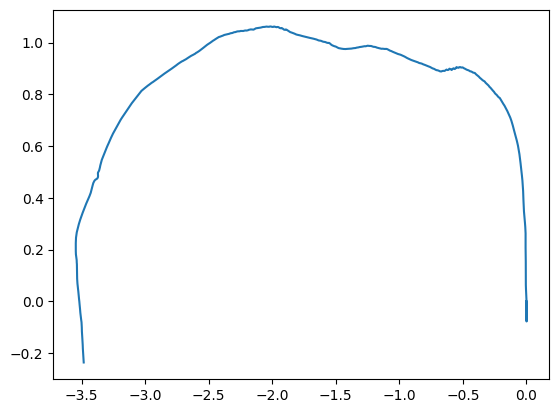

In [ ]:
x_feature_tracking = [frame.pose[0, 3] for frame in frames]
z_feature_tracking = [frame.pose[2, 3] for frame in frames]

plt.plot(x_feature_tracking, z_feature_tracking)
plt.show()

### **Differenza tra i due path**

Nel seguito viene mostrata la differenza tra i due path. Già con un percorso così breve si nota come ci possano essere discrepanze nel tragitto stimato dai due diversi algoritmi. Questa discrepanza si accumula nel tempo, portando ad errori anche molto elevati dopo diversi minuti di esplorazione. Per questo motivo è essenziale un modulo dedicato alla loop closure detection e un back-end che corregga gli errori.

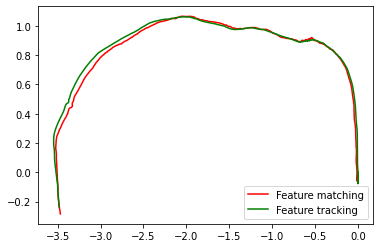

In [ ]:
fig, ax = plt.subplots()
ax.plot(x_feature_matching, z_feature_matching, color = "red", label = "Feature matching")
ax.plot(x_feature_tracking, z_feature_tracking, color = "green", label = "Feature tracking")
ax.legend()

# **Considerazioni finali**

Come detto, questo seminario sulla Visual Odometry rappresenta solo una piccola parte di un problema complesso che è lo SLAM.
Spero comunque che le cose viste vi siano chiare e che questo magari sia uno spunto per addentrarsi e approfondire questa tematica di ricerca che sta diventando sempre più calda nella comunità scientifica, negli ultimi anni specialmente si stanno moltiplicando le ricerche in tale ambito.

Altre parti dello SLAM si stanno spostando verso soluzioni basate su intelligenza artificiale e metodi maggiormente cognitivi per effettuare il mapping, al contrario dell'odometria.
L'odometria è un tema molto particolare, è di fatto uno dei pochi problemi rimasti per cui le tecniche tradizionali che abbiamo visto oggi continuano a performare meglio di tecniche basate su reti neurali. La stima dell'odometria è infatti un problema geometrico per cui esistono algoritmi come il PnP che lo risolvono in modo preciso e non risulta quindi utile addestrare reti neurali per imparare a farlo.


Per qualsiasi dubbio o domanda potete contattarmi alla mia mail [matteo.scucchia2@unibo.it](mailto:matteo.scucchia2@unibo.it).

## **Riferimenti interessanti**

Paper sulla Visual Odometry parte [1](https://rpg.ifi.uzh.ch/docs/VO_Part_I_Scaramuzza.pdf) e [2](https://rpg.ifi.uzh.ch/docs/VO_Part_II_Scaramuzza.pdf).

[Libro completo](https://github.com/gaoxiang12/slambook-en/blob/master/slambook-en.pdf) sullo SLAM con [codice](https://github.com/gaoxiang12/slambook2) realizzato in C++, OpenCV e altre librerie comunemente usate in tale ambito.